# PDS federated API demo, Osiris-Rex OVIRS data visualization
# PART 1: EXPLORE A COLLECTION

The purpose of this notebook is to demostrate how the PDS web API can be used to access the PDS data for a scientific use case.

The documention of the PDS web API is available on https://nasa-pds.github.io/pds-api/

This notebook is available on https://github.com/NASA-PDS/pds-api-notebook

<b>2 Use cases:</b>
 - <u>Part1</u>: explore the collection
 - <u>Part2</u>: find/visualize specific the data you are interested in
 
 <br/>
 
 WARNING: This notebook is a demo and not a real scientific use case. It might contain mistake in the way the data is used or displayed.

In [1]:
from __future__ import print_function
from pprint import pprint
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

The PDS API is accessed using a python client library documented on https://nasa-pds.github.io/pds-api-client/

In [2]:
import pds.api_client as pds_api

## Use the PDS demo web API server 

Connect to the demo server. See User Interface of the web API: https://pds-gamma.jpl.nasa.gov/api/swagger-ui.html

<b>Note: </b> this piece of code will be wrapped into a helper function so that 1 line will be enough to connect to the API using a default host

In [3]:
configuration = pds_api.Configuration()

# demo server
configuration.host = 'https://pds-gamma.jpl.nasa.gov/api/'

api_client = pds_api.ApiClient(configuration)


## Explore a collection

### Get the lidvid of your collection of interest

Search for a collection of interest on https://pds.nasa.gov/datasearch/keyword-search/ (or https://pds.nasa.gov > Data Search > Keyword Search):
- Search for "osiris rex calibrated ovirs collection" (https://pds.nasa.gov/datasearch/keyword-search/search.jsp?q=osiris+rex+ovirs+calibrated+collection)
- Click on the first collection on the results
- Copy the lidvid


### Get the properties available for the observational products belonging to the selected collection

Get the properties available for the product belonging to the collection of interest using `CollectionsProductsApi.products_of_a_collection` 
(see https://nasa-pds.github.io/pds-api-client/api/api_client.api.html#api_client.api.collections_products_api.CollectionsProductsApi)

API responses have the structure `{"summary": {}, data= []}`
(see https://nasa-pds.github.io/pds-api-client/api/api_client.models.html#api_client.models.products.Products)

We do not get the product descriptions yet but only the available properties with `only_summary=True` option.

In [4]:
lidvid = 'urn:nasa:pds:orex.ovirs:data_calibrated'

collection_products_api = pds_api.CollectionsProductsApi(api_client)
api_response = collection_products_api.products_of_a_collection(lidvid , start=0, limit=20, only_summary=True)

print(f"The available properties for the selected products are {api_response.summary.properties}")

The available properties for the selected products are ['pds:Modification_Detail.pds:description', 'pds:Axis_Array.pds:axis_name', 'pds:Local_Internal_Reference.pds:local_reference_type', 'pds:File.pds:file_size', 'pds:Modification_Detail.pds:modification_date', 'orex:Spatial.orex:bennu_radec_target', 'orex:Spatial.orex:emission_angle', 'pds:Internal_Reference.pds:lidvid_reference', 'ops:Label_File_Info.ops:md5_checksum', 'vid', 'orex:Spatial.orex:bore_angle', 'orex:Mission_Information.orex:mission_phase_identifier', 'orex:Spatial.orex:phase_angle', 'pds:Array_2D_Spectrum.pds:axes', 'orex:Time.orex:mid_obs', 'pds:Observing_System_Component.pds:type', 'orex:Spatial.orex:declination', 'sp:Observation_Parameters.sp:resolution_limit_wavelength', 'sp:Observation_Parameters.sp:net_integration_time', 'orex:Time.orex:mid_obs_et', 'sp:Spectral_Characteristics.sp:spectral_bin_type', 'pds:Axis_Array.pds:sequence_number', 'ops:Data_File_Info.ops:md5_checksum', 'pds:Identification_Area.pds:title', 

### Request specific properties of all the observational products of the collection

Properties have a syntax alike the PDS4 model: class/attributes. 

Get the latitude, longitude and target_range of the observational products belonging to the collection, with `fields=` option.

The API results are <b>paginated</b>, to get all the results we need to loop through the pages.

In [5]:
properties_of_interest = ['orex:spatial.orex:latitude', 'orex:spatial.orex:longitude', 'orex:spatial.orex:target_range']

start = 0
limit = 500
products = []
pbar = tqdm()

start_time = time.time()
while True:
    pbar.update(int(start/500))
    
    api_response = collection_products_api.products_of_a_collection(
        lidvid, 
        start=start, 
        limit=limit, 
        fields=properties_of_interest)

    if api_response.data:
        products.extend(api_response.data)
        start += limit
    else:
        break

elapsed = time.time() - start_time
print(f'retrieved {start} products in {elapsed/60.0:.1f} minutes')

pbar.close()



0it [00:00, ?it/s]

retrieved 279500 products in 13.5 minutes


### Product description comes with default properties + requested properties

See for example

In [6]:
products[140000]

{'description': None,
 'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20181103t073051s132_ovr_scil2.fits::1.0',
 'investigations': [{'description': None,
                     'href': 'https://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex',
                     'title': None,
                     'type': None}],
 'metadata': {'creation_date_time': '2019-04-13T01:02:37.516Z',
              'label_url': 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/approach/20181103T073051S132_ovr_scil2.xml',
              'update_date_time': None,
              'version': '1.0'},
 'observing_system_components': [{'description': None,
                                  'href': 'https://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:pds:cont

### Filter out records with no valid values

Some records have fill values for the fields we are interested in (e.g. `latitude == -9999`, we want to remove them from our results.


In [7]:
def at_least_one_valid_value(p):
    return ((p['orex:spatial.orex:latitude'] !=  '-9999') \
           and (p['orex:spatial.orex:latitude'] != None))

def filter_out_fillvalues(products):
    properties = []
    for product in products:
        if at_least_one_valid_value(product.properties):
            p = product.properties
            p['id'] = product.id
            properties.append(p)
    return properties

properties = filter_out_fillvalues(products)
        
print(f"The values of the selected properties are")
pprint(properties[:3])

The values of the selected properties are
[{'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20181102t041236s859_ovr_scil2.fits::1.0',
  'orex:spatial.orex:latitude': '-22.546203099740598',
  'orex:spatial.orex:longitude': '29.6493567602281',
  'orex:spatial.orex:target_range': '197.757787474397'},
 {'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20181102t041237s759_ovr_scil2.fits::1.0',
  'orex:spatial.orex:latitude': '-18.1849081622853',
  'orex:spatial.orex:longitude': '16.445177388920598',
  'orex:spatial.orex:target_range': '197.757720053807'},
 {'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20181102t041238s659_ovr_scil2.fits::1.0',
  'orex:spatial.orex:latitude': '-14.845147832590499',
  'orex:spatial.orex:longitude': '7.29380975545429',
  'orex:spatial.orex:target_range': '197.757652690671'}]


### Transpose to extract lat,lon and target range as columns, ready to plot 

In [8]:
def transpose(properties):
    lat = [float(p['orex:spatial.orex:latitude']) for p in properties]
    lon = [float(p['orex:spatial.orex:longitude']) for p in properties]
    target_range = [float(p['orex:spatial.orex:target_range']) for p in properties]
    return lat, lon, target_range

lat, lon, target_range = transpose(properties)
print(f'The target_range values for the selected products are {target_range[:3]}')

The target_range values for the selected products are [197.757787474397, 197.757720053807, 197.757652690671]


### Plot the lat,lon of the observations, colored by target_range

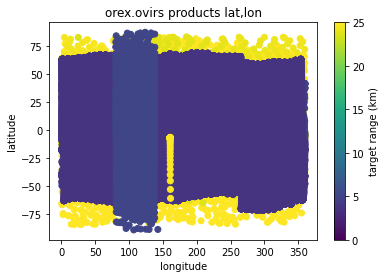

In [9]:
def observation_map(lat, lon, target_range, vmax=25):
    fig, ax = plt.subplots()

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('orex.ovirs products lat,lon')

    im = ax.scatter(lon, lat, c=target_range, vmin=0, vmax=vmax)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('target range (km)')
    
observation_map(lat,lon, target_range, vmax=25)


### Overview of the observation target_range with an histogram

(array([    0.,     0., 32390., 18425.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

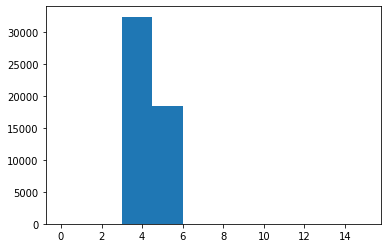

In [10]:
plt.hist(target_range, range=(0, 15))

### Get observations around specific spot (lat=12, lon=24) with target range closer than 4 km

In [11]:
lidvids = [p['id'] for p in properties if float(p['orex:spatial.orex:target_range']) < 4.0 
          and abs(float(p['orex:spatial.orex:latitude']) - 12.0) < 3.0
          and abs(float(p['orex:spatial.orex:longitude']) - 24.0) < 3.0]
print(f'The lidvids of the selected products are {lidvids}')

The lidvids of the selected products are ['urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204128s567_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204129s468_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204130s368_ovr_scil2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204131s368_ovr_scil2.fits::1.0']


### Get the full product description

In [12]:
products_api = pds_api.ProductsApi(api_client)
product = products_api.products_by_lidvid(lidvids[0])
print(product)

{'description': None,
 'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20190321t204128s567_ovr_scil2.fits::1.0',
 'investigations': [{'description': None,
                     'href': 'https://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex',
                     'title': None,
                     'type': None}],
 'metadata': {'creation_date_time': '2019-10-23T19:05:39.752Z',
              'label_url': 'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204128S567_ovr_scil2.xml',
              'update_date_time': None,
              'version': '1.0'},
 'observing_system_components': [{'description': None,
                                  'href': 'https://pds-gamma.jpl.nasa.gov/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:p

### Get the file path of the data

In [22]:
product.properties['ops:Data_File_Info.ops:file_ref']

'https://pds-gamma.jpl.nasa.gov/data/pds4/test-data/registry/orex.ovirs/data_calibrated/bennu_original_calibration/detailed_survey/20190321T204128S567_ovr_scil2.fits'